Voy a usar los datos de Temperatura, Precipitacion del dia anterior y Presion ya que son con los que mejores resultados he obtenido hasta ahora. Usaré Optuna para optimizar los modelos para obtener mejores resultados.

Ademas seguire poniendo equilibrando el undersampling solo de los datos de entrenamiento, y eligiendo parcelas enteras como datos de test.

In [1]:
def algoritmo(df2, fecha, show, parcela):
    diasTotales = 365 + 31
    #from IPython.core.display import display, HTML
    #display(HTML("<style>div.output_scroll { height: 90em; }</style>"))

    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import datetime

    import warnings
    warnings.filterwarnings("ignore")
    
    borrarDebajo = 0.15
    
    fechas = list()
    fechas2 = list()
    valores = list()
    valores2= list()
    N = int(df2.size / 3) #numero de valores que tenemos para esta parcela

    #Almacenamos los datos originales de la parcela en 'fechas' y 'valores'
    #En 'fechas2' y 'valores2' almacenamos los datos cuyo ndvi esté por encima de 'borrarDebajo'
    for i in range(N):
        data = df2.iloc[i].fecha
        data = str(data)
        #Esto convierte la cadena YYYYMMDD en un tipo de dato fecha
        dt = datetime.datetime.strptime(data, "%Y%m%d")
        dtInt = int(dt.strftime("%j"))
        if int(data) >= 20220000:
            dtInt = dtInt +365
        #Convierto ese tipo de dato fecha en un entero, el dia del año de esa fecha
        #Ej. 20210202 es el 2 de febrero y es el dia 33 del año
        fechas.append(dtInt)
        ndvi = df2.iloc[i].ndvi
        valores.append(ndvi)
        #Solo añado si el valor está por encima de la variable "borrarDebajo"
        if ndvi >= borrarDebajo:
            valores2.append(ndvi)
            fechas2.append(dtInt)

    #Borramos de 'valores2' y 'fechas2' los datos cuyos ndvi sean menores que el dato anterior y al siguiente (valores valle)
    #Ejemplo: si tenemos los valores [3,1,2,4], borramos los valores 1 y 2
    #Si tenemos los valores [3,1,4], borramos el valor 1
    #Borramos los valores valle
    for i in range(len(valores2)-1):
        if i > 0 and i < len(valores2)-1:
            #Si hay 2 valores juntos menores que el anterior y el siguiente, se borran ambos
            if i < (len(valores2) - 2) and valores2[i-1] > valores2[i] and valores2[i-1] > valores2[i+1] and valores2[i+2] > valores2[i] and valores2[i+2] > valores2[i+1]:
                del valores2[i]
                del fechas2[i]
                del valores2[i]
                del fechas2[i]
            #En el caso de que solo haya un minimo entre 2 puntos
            elif valores2[i-1] > valores2[i] and valores2[i+1] > valores2[i]:
                del valores2[i]
                del fechas2[i]        






    #Variables:
    saltoFechas = 10
    saltoFechas2 = 20
    saltoFechas3 = 30
    añadirPorDebajo = 0.4 #antes se llamaba maximoMinimo
    añadirPorEncima = 0.2

    #Añado informacion al principio y final de año si no habia
    if fechas2[0] > 0:
        fechas2.insert(0, 0)
        valores2.insert(0, valores2[0])
    if fechas2[len(fechas2) -1] < diasTotales:
        fechas2.insert(len(fechas2), diasTotales)
        valores2.insert(len(valores2), valores2[len(valores2)-1])


    #Si hay saltos muy grandes sin informacion se trata:
    i = 0
    while i < len(fechas2) - 1: 
        encontrado = False
        #Si el salto es muy grande
        if (fechas2[i+1]-fechas2[i]) >= saltoFechas3 and i+1 != (len(fechas2) -1) and i != 0:
            #buscar maximos locales entre los dos puntos y
            aux1 = 0
            aux2 = 0
            for j in range(len(fechas) - 1):
                if fechas[j] <= fechas2[i] and fechas[j+1] >= fechas2[i]:
                    aux1 = j
                elif fechas[j] <= fechas2[i]  and fechas[j+1] >= fechas2[i]   :
                    aux2 = j
                    break
            j = aux1 + 1
            auxSum = 0
            while (j < aux2):
                if valores[j] > valores[j-1] and valores[j] > valores[j+1]:
                    # y volverlos a añadir segun su valor
                    if (valores2[i] <= 0.6 and valores2[i+1] <=0.6 and valores[j] <= añadirPorDebajo and valores[j] >= añadirPorEncima):
                        fechas2.insert(i+1+ auxSum, fechas[j])
                        valores2.insert(i+1+ auxSum, valores[j])
                        auxSum = auxSum + 1
                        encontrado = True
                j = j + 1



        if encontrado == False:    
            #Si el salto es intermedio
            if (fechas2[i+1]-fechas2[i]) >= saltoFechas2:
                if valores2[i+1] > valores2[i]: #va hacia arriba
                    fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3)*2)
                    valores2.insert(i+1, valores2[i] + ((valores2[i+1] - valores2[i]) / 3))
                else: #va hacia abajo
                    fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3))
                    valores2.insert(i+1,  valores2[i+1] + ((valores2[i] - valores2[i+1]) / 3))
            #Si el salto es pequeño
            elif (fechas2[i+1]-fechas2[i]) >= saltoFechas:
                fechas2.insert(i+1, (fechas2[i+1]+fechas2[i])/2)
                valores2.insert(i+1, (valores2[i+1]+valores2[i])/2)
        i = i+1


    #Plot    
    from scipy.interpolate import make_interp_spline
    from scipy.interpolate import interp1d

    #Esto crea una linea de <diasTotales> puntos que pasa por todos los puntos que teniamos
    X_Y_Spline = make_interp_spline(fechas2,valores2)        
    X = np.linspace(0, diasTotales, diasTotales)
    Y = X_Y_Spline(X)

    dt = datetime.datetime.strptime(fecha, "%Y%m%d")
    aux = int(dt.strftime("%j"))
    
    if (show):
        plt.figure(figsize=(17,5))
        plt.title('parcela: '+ parcela)
        plt.plot(fechas, valores,'r-')

        plt.xticks(np.arange(0, diasTotales,10))

        plt.plot(X, Y, 'b-')
        plt.scatter(fechas, valores, c=valores, cmap='Set2')

        #Dibujar las lineas verticales asociadas a las fechas de recepcion
        #for recepcion in recepciones:
        #    if recepcion[0] == parcela:
        #        for aux in recepcion[1]:
        #            dt = datetime.datetime.strptime(aux, "%Y%m%d")
        #            aux2 = int(dt.strftime("%j"))
        #            plt.axvline(x=(aux2))  
        #        break

        #dt = datetime.datetime.strptime(fecha, "%Y%m%d")
        #aux = int(dt.strftime("%j"))
        plt.axvline(x=(aux))  



        plt.xlabel("X")
        plt.ylabel("Y")
        plt.ylim([0, 1])
        plt.legend(["puntos originales","puntos modificados"])
        plt.show()
        
    return [Y, aux]

def obtenerColumnas():
    columnas = list()
    columnas.append('parcela')
    columnas.append('dia')
    columnas.append('pendiente dia -15')
    columnas.append('pendiente dia -10')
    columnas.append('pendiente dia -5')
    columnas.append('ndvi')
    columnas.append('recogido')
    
    return columnas

def inicializarDataframeIA(columnas):
    import pandas as pd
    df_ia = pd.DataFrame(columns=columnas())
    
    return df_ia

def obtenerParcelasConUnaRecepcion(PARCELASMAIZ20212022CONFECHAS):
    import pandas as pd

    dfFechas = pd.read_csv(PARCELASMAIZ20212022CONFECHAS)
    
    freq = dfFechas['PAC'].value_counts()
    items = freq[freq==1].index
    only_1_reception = dfFechas[dfFechas['PAC'].isin(items)]

    newPac = only_1_reception["PAC"].str.replace(":", "_")
    newDate = only_1_reception["Fecha de carga"].str.replace("-", "")

    only_1_reception["PAC"] = newPac
    only_1_reception["Fecha de carga"] = newDate
    only_1_reception['Fecha de carga'] = only_1_reception['Fecha de carga'].apply(str)
    
    return only_1_reception

def añadirADataframe(parcela, diaDeCarga, valoresDias, columnas, df,diasPendiente, diasMargen):
    import pandas as pd
    for i in range(len(valoresDias)):
        if ((i - (diasPendiente[0])) >= 0 and (i+1) - diaDeCarga > -15 and (i+1) - diaDeCarga <= 5  ):
            
            lista = list()
            lista.append(parcela)
            lista.append(i + 1)
            for j in diasPendiente:
                lista.append((valoresDias[i - j] - valoresDias[i])/j)
                
            lista.append(valoresDias[i])
            if ((diaDeCarga - (i + 1)) <= diasMargen and (diaDeCarga - (i + 1)) >= 0):
                lista.append(1)
            else:
                lista.append(0)

            dfAux = pd.DataFrame([lista], columns=columnas(), index=[len(df)])
            df = df.append(dfAux)
    
    
    return df


def obtenerDatosEntrenables(datosNoEntrenables2122, PARCELASMAIZ20212022CONFECHAS):
    import pandas as pd
    dfFechas = obtenerParcelasConUnaRecepcion(PARCELASMAIZ20212022CONFECHAS)
    
    
    dfDatos = pd.read_csv(datosNoEntrenables2122)
    dfDatos = dfDatos.sort_values(by=["fecha","parcela"], ascending=True)
    
    parcelasQueTengo = dfDatos["parcela"].unique()
    parcelasConUnaRecepcion = dfFechas["PAC"].unique()

    df_ndvi_of_only_1_reception = dfDatos[dfDatos.parcela.isin(dfFechas["PAC"].unique())]
    parcelas = df_ndvi_of_only_1_reception['parcela'].unique()
    
    
    df = inicializarDataframeIA(obtenerColumnas)
    i = 0
    j = len(parcelas)
    diaPrimeraRecepcion = [15,10,5]
    diaMargen = 4
    
    
    for parcela in parcelas:

        df2 = df_ndvi_of_only_1_reception.loc[df_ndvi_of_only_1_reception['parcela'] == parcela]
        df2 = df2.drop_duplicates()
        if (not df2.empty):
            fecha_df = dfFechas.loc[dfFechas["PAC"] == parcela] 
            fecha = fecha_df.iloc[0]["Fecha de carga"]
            X, dia_recepcion = algoritmo(df2, fecha, True, parcela)
            if (dia_recepcion > diaPrimeraRecepcion[0]):
                df = añadirADataframe(parcela, dia_recepcion, X, obtenerColumnas, df, diaPrimeraRecepcion, diaMargen)
            i = i + 1
            print(str(i) + "/" + str(j)) 
        else:
            j = j - 1
        

    return df

def separarTrainTest(dataframe):
    parcelas = dataframe['parcela'].unique()
    N = len(parcelas)

    #si hay 2 recintos de la misma zona uno lo meto a test
    test= list()
    train = list(parcelas)
    contador = 1
    for i in range(N):
        parcelaAnterior = parcelas[i - 1].split('_')
        aux = ''
        for j in range(5):
            aux = aux + parcelaAnterior[j] + '_'


        if parcelas[i].startswith(aux):
            test.append(parcelas[i])
            train.remove(parcelas[i])
            if len(test) >= N * 0.1:
                break

    dataframeTrain = dataframe[dataframe['parcela'].isin(train)]
    dataframeTest =  dataframe[dataframe['parcela'].isin(test)]
    
    return [dataframeTrain, dataframeTest]

def obtenerModelo(dataframeTrain, regularizacion=1):
    # Perceptron de un solo nivel
    from keras.layers import Dense
    from keras.regularizers import l2
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    
    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    
    normalizer = layers.Normalization()
    normalizer.adapt(X)
    
    n = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1]

    model = Sequential()
    
    model.add(normalizer)
    #,kernel_initializer=initializer
    #model.add(Dense(n**3, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    #añadir capa
    model.add(Dense(n**2, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    model.add(Dense(n, activation='relu', kernel_regularizer=l2(regularizacion)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(regularizacion)))
    #
    model.compile(loss='binary_crossentropy', optimizer=Adam(),  metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.6), keras.metrics.Recall(name='recall', threshold = 0.6)])
    model.summary()
    
    return model

def obtenerModelo3(dataframeTrain, regularizacion=1):
    # Perceptron de un solo nivel
    from keras.layers import Dense
    from keras.regularizers import l2
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    
    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    
    normalizer = layers.Normalization()
    normalizer.adapt(X)
    
    n = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1]

    model = Sequential()
    
    model.add(normalizer)
    #,kernel_initializer=initializer
    #model.add(Dense(n**3, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    #añadir capa
    #model.add(Dense(n**2, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    model.add(Dense(n, activation='relu',input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(regularizacion)))
    #
    model.compile(loss='binary_crossentropy', optimizer=Adam(),  metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.6), keras.metrics.Recall(name='recall')])
    model.summary()
    
    return model

def obtenerModelo4(dataframeTrain, regularizacion=1):
    # Perceptron de un solo nivel
    from keras.layers import Dense
    from keras.regularizers import l2
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    
    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    
    normalizer = layers.Normalization()
    normalizer.adapt(X)
    
    n = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1]

    model = Sequential()
    
    model.add(normalizer)
    #,kernel_initializer=initializer
    model.add(Dense(n**3, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    #añadir capa
    model.add(Dense(n**2, activation='relu',  kernel_regularizer=l2(regularizacion)))
    model.add(Dense(n, activation='relu', kernel_regularizer=l2(regularizacion)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(regularizacion)))
    #
    model.compile(loss='binary_crossentropy', optimizer=Adam(),  metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.6), keras.metrics.Recall(name='recall', threshold = 0.6)])
    model.summary()
    
    return model

def obtenerModelo5(dataframeTrain, regularizacion=1):
    # Perceptron de un solo nivel
    from keras.layers import Dense
    from keras.regularizers import l2
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    from tensorflow.keras.layers import Dropout
    from tensorflow.keras.constraints import MaxNorm
    from tensorflow.keras.optimizers import SGD
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    
    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    
    normalizer = layers.Normalization()
    normalizer.adapt(X)
    
    n = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1]

    model = Sequential()
    
    model.add(normalizer)
    #,kernel_initializer=initializer
    # Compile model
    #añadir capa
    model.add(Dense(n, activation='relu', input_shape=(n,), kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='relu', kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    #
    sgd = SGD(learning_rate=0.1, momentum=0.9)
    model.compile(loss='binary_crossentropy', optimizer=sgd,  metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.6), keras.metrics.Recall(name='recall')])
    model.summary()
    
    return model

def obtenerModelo2(dataframeTrain):
    # Perceptron de un solo nivel
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    normalizer = layers.Normalization()
    normalizer.adapt(X) 
    
    model = Sequential()
    
    #model.add(normalizer)
    
    model.add(Dense(4096, kernel_initializer='normal',input_dim = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1], activation='sigmoid'))

    # The Hidden Layers :
    model.add(Dense(2048 ,activation='softmax'))
    model.add(Dense(1024 ,activation='sigmoid'))
    model.add(Dense(512,activation='relu'))
    model.add(Dense(256,activation='softmax'))
    model.add(Dense(128,activation='sigmoid'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(32,activation='softmax'))
    model.add(Dense(16,activation='sigmoid'))
    model.add(Dense(8,activation='relu'))
    model.add(Dense(4,activation='softmax'))
    
    model.add(Dense(2, activation='softmax'))
    #
    model.compile(loss='categorical_crossentropy', optimizer=Adam(),  metrics=['accuracy'])
    model.summary()
    
    return model

def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    fig, axs = plt.subplots(1, 2,  figsize=(12, 6))
    for l in loss_list:
        axs[0].plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        axs[0].plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    axs[0].set(title='Loss', xlabel='Epochs', ylabel='Loss')
    axs[0].grid()
    axs[0].legend()
    
    ## Accuracy
    for l in acc_list:
        axs[1].plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        axs[1].plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    axs[1].set(title='Accuracy', xlabel='Epochs', ylabel='Accuracy')
    axs[1].grid()
    axs[1].legend()
    plt.show()
    
def anyadirUnos(df):
    df['unos'] = [1]*len(df)
    
def RecepcionToBool(recogido):
    aux = np.zeros(2)
    aux[recogido] = 1
    return aux
            
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    #plt.tight_layout()

def plot_mnist_confusion_matrix(y_test, y_pred, normalize=False):
    from sklearn.metrics import confusion_matrix
    
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers
    umbral = 0.01
    
    y_tst = np.zeros(len(y_test))
    for i in range(len(y_test) - 1):
        #if y_test[i][1] >= umbral:
        #    y_tst[i] = 1
        y_tst[i] = np.argmax(y_test[i])
    #y_tst = [np.argmax(y) for y in y_test]
    
    y_prd = np.zeros(len(y_pred))
    for i in range(len(y_pred) - 1):
        #if y_pred[i][1] >= umbral:
        #    y_prd[i] = 1
        y_prd[i] = np.argmax(y_pred[i])
    #y_prd = [np.argmax(y) for y in y_pred]

    cnf_matrix = confusion_matrix(y_tst, y_prd)
    
    yprueba = list()
    for y in y_tst:
        yprueba.append(y)
    for y in y_prd:
        yprueba.append(y)
    class_names=np.unique(yprueba)
    print(class_names)
    plt.figure(figsize=(20,20))
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          normalize=normalize)
    
def quitarDatosMalos(df):
    #QUITA LAS PARCELAS QUE NO TENGAN 20 DIAS DE DATOS
    parcelasAQuitar = list()
    parcelas = df['parcela'].unique()
    for parcela in parcelas:
        if len(df.loc[df['parcela'] == parcela]) != 20:
            parcelasAQuitar.append(parcela)
    
    df = df[~df['parcela'].isin(parcelasAQuitar)]
    return df
    
def anyadirRelacionesParametros2(df):
    columnas = df.shape[1]
    for i in range(columnas):
        for j in range(columnas):
            if i < j:
                nombreColumna = 'col ' + str(i+1) + ' * col ' + str(j+1)
                df[nombreColumna] = df.iloc[:,i] * df.iloc[:,j]
                
    return df
    
def anyadirRelacionesParametros(df, listaColumnas = ['parcela','dia','recogido','ndvi']):
    aux = pd.DataFrame()
    for i in listaColumnas:
        aux[i] = df[i]
        df = df.drop(columns=[i])
        
    df = anyadirRelacionesParametros2(df)
    for i in listaColumnas:
        df[i] = aux[i]
    return df
    
def entrenarModelo(model, dataframeTrain, dataframeTest, batch_size, epochs, callbacks_list):
    def RecepcionToBool(recogido):
        aux = np.zeros(2)
        aux[recogido] = 1
        return aux

    #DATA TRAINING   
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers
    N = len(dataframeTrain)


    verbose = True
    t0 = time.perf_counter()
    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    y = np.asarray(dataframeTrain[["recogido"]]).astype(np.float32)
    
    #DATA TESTING
    N = len(dataframeTest)

    Xtest = np.asarray(dataframeTest.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    ytest = np.asarray(dataframeTest[["recogido"]]).astype(np.float32)
    


    history = model.fit(X, y,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=False, 
                        callbacks=callbacks_list,
                       validation_data=(Xtest,ytest))

    #model.predict(X_cv)

    train_time = time.perf_counter() - t0
    print('%s %.3f%s' %  ('Training time: ', train_time, 's') )
    plot_history(history)
    
def predecirYMostrarMatrizConfusion(df,model,pesos, umbral = 0.6):
    df = df.reset_index()
    df = df.drop(columns=['index'])
    X = df.drop(columns=['parcela','dia','recogido'])
    y = df['recogido']
    
    X=np.asarray(X).astype(np.float)

    y=np.asarray(y).astype(np.float)
    
    model.load_weights(pesos)
    
    
    
    y_pred = model.predict(X, verbose=True)
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for i in range(len(y_pred)):
        if y_pred[i] >= umbral and y[i] == 1:
            tp = tp + 1
        elif y_pred[i] >= umbral and y[i] == 0:
            fp = fp + 1
        elif y_pred[i] < umbral and y[i] == 1:
            fn = fn + 1
        else:
            tn = tn + 1


    test_score = (tp + tn)/ len(X)
    print('%s %2.2f%s' % ('Accuracy test:  ', 100*test_score, '%'))

    import seaborn as sn
    import pandas as pd
    import matplotlib.pyplot as plt
    ind = np.asarray([0.0,1.0]).astype(np.float32)
    mat = np.asarray([[tn, fp], [fn, tp]]).astype(np.int32)
    plt.figure(figsize=(20,20))
    plot_confusion_matrix(mat, classes=ind,
                              normalize=False)



# Define la función de poda
def prune_low_weights(model, pruning_threshold):
    from keras import backend as K
    for layer in model.layers:
        if hasattr(layer, 'kernel_regularizer'):
            weights = layer.get_weights()[0]  # Obtiene los pesos de la capa
            mask = K.abs(weights) > pruning_threshold  # Aplica el umbral
            weights *= mask  # Poda los pesos por debajo del umbral
            layer.set_weights([weights])  # Establece los pesos podados en la capa
            
def parcelasConAciertos(dataframe,model,  umbral = 0.6, verbose=1, XGBoost = False, LGBM= False):
    import lightgbm as lgb
    import xgboost as xgb
    dataframeRecogidoUno = dataframe.loc[dataframe['recogido'] == 1]
    parcelasAObservar = dataframe['parcela'].unique()
    parcelasSinResultado = list(dataframe['parcela'].unique())
    if verbose == 1:
        print(len(parcelasSinResultado))
        print("hay ", str(len(parcelasAObservar)), " parcelas a observar")
        print('------------------')
    cantidad = 0
    for parcela in parcelasAObservar:
        unoAcertado = False
        datos = dataframe.loc[dataframe['parcela'] == parcela]
        dias = dataframeRecogidoUno.loc[dataframeRecogidoUno['parcela'] == parcela]['dia']
        if verbose == 1:
            print(parcela, 'dias que deberia dar 1 la prediccion:')
            print(dias)
        Xtest = np.asarray(dataframe.loc[dataframe['parcela'] == parcela].drop(columns=['parcela','dia','recogido'])).astype(np.float32)
        ytest = np.asarray(dataframe.loc[dataframe['parcela'] == parcela][["recogido"]]).astype(np.float32)
        
        # preparar datos de xgboost
        if XGBoost == True:
            X_test = pd.DataFrame(Xtest, columns=dataframe.drop(columns=['recogido','parcela','dia']).columns)
            Xtest = xgb.DMatrix(X_test, label=ytest)
        # preparar datos de lgbm
        elif LGBM == True:
            X_test = pd.DataFrame(Xtest, columns=dataframe.drop(columns=['recogido','parcela','dia']).columns)
            Xtest = X_test.values
        
        # predicciones
        if hasattr(model, 'predict_proba'):
            ypred = model.predict_proba(Xtest)[:,1]
        else:
            if 'verbose' in model.predict.__code__.co_varnames:
                ypred = model.predict(Xtest, verbose=verbose)
            else:
                ypred = model.predict(Xtest)
            
            
        if verbose == 1:
            print("dias que ha dado 1 la prediccion: ")
        for i in range(len(ypred)):
            if ypred[i] >= umbral:
                if verbose == 1:
                    print('dia: ', datos.iloc[i]['dia'])
                if ytest[i] == 1 and unoAcertado == False:
                    cantidad = cantidad + 1
                    unoAcertado = True
                    
                    
        if (unoAcertado == True):
            if verbose == 1:
                print("ha acertado por lo menos un 1 de los que deberia")
            parcelasSinResultado.remove(parcela)

        if verbose == 1:
            print('------------------')

    print('Parcelas con acierto: ',cantidad, "de", str(len(parcelasAObservar)) , " ", "{:.2%}".format(cantidad/len(parcelasAObservar)))
    return [parcelasAObservar, parcelasSinResultado]
    
    
def obtenerMejorModelo(directory_init = ''):
    import os
    import ipynbname
    if directory_init == '':
        directory = ipynbname.name()
    else:
        directory = directory_init
    baccuracyMax = 0
    baccuracyMaxFile = ''
    val_baccuracyMax = 0
    val_baccuracyMaxFile = ''
    recallMax = 0
    recallMaxFile = ''
    val_recallMax = 0
    val_recallMaxFile = ''
    # iterate over files in
    # that directory
    for subdirectory in os.listdir(directory):
        f = os.path.join(directory, subdirectory)
        # checking if it is a file
        for filename in os.listdir(f):
            campos = filename.split('-')
            f1 = os.path.join(f, filename)
            if (len(campos)) == 5:
                if (campos[3] == 'binary_accuracy' and float(campos[4][:len(campos[4])-5]) > float(baccuracyMax)):
                    baccuracyMax = float(campos[4][:len(campos[4])-5])
                    baccuracyMaxFile = f1
                if (campos[3] == 'val_binary_accuracy' and float(campos[4][:len(campos[4])-5]) > float(val_baccuracyMax)):
                    val_baccuracyMax = float(campos[4][:len(campos[4])-5])
                    val_baccuracyMaxFile = f1
                if (campos[3] == 'recall' and float(campos[4][:len(campos[4])-5]) > float(recallMax)):
                    recallMax = float(campos[4][:len(campos[4])-5])
                    recallMaxFile = f1
                if (campos[3] == 'val_recall' and float(campos[4][:len(campos[4])-5]) > float(val_recallMax)):
                    val_recallMax = float(campos[4][:len(campos[4])-5])
                    val_recallMaxFile = f1

    print("Mejor binary_accuracy: ", baccuracyMax)
    print(baccuracyMaxFile)
    print("Mejor val_binary_accuracy: ", val_baccuracyMax)
    print(val_baccuracyMaxFile)
    print("Mejor recall: ", recallMax)
    print(recallMaxFile)
    print("Mejor val_recall: ", val_recallMax)
    print(val_recallMaxFile)


In [2]:
def mostrarParcelasSinAciertos(parcelasAObservar):

    def algoritmo(df2, fecha, show, tp, fp):

        #from IPython.core.display import display, HTML
        #display(HTML("<style>div.output_scroll { height: 90em; }</style>"))

        import pandas as pd
        import matplotlib.pyplot as plt
        import numpy as np
        import datetime

        import warnings
        warnings.filterwarnings("ignore")

        borrarDebajo = 0.15

        fechas = list()
        fechas2 = list()
        valores = list()
        valores2= list()
        N = int(df2.size / 3) #numero de valores que tenemos para esta parcela

        #Almacenamos los datos originales de la parcela en 'fechas' y 'valores'
        #En 'fechas2' y 'valores2' almacenamos los datos cuyo ndvi esté por encima de 'borrarDebajo'
        for i in range(N):
            data = df2.iloc[i].fecha
            data = str(data)
            #Esto convierte la cadena YYYYMMDD en un tipo de dato fecha
            dt = datetime.datetime.strptime(data, "%Y%m%d")
            #Convierto ese tipo de dato fecha en un entero, el dia del año de esa fecha
            #Ej. 20210202 es el 2 de febrero y es el dia 33 del año
            fechas.append(int(dt.strftime("%j")))
            ndvi = df2.iloc[i].ndvi
            valores.append(ndvi)
            #Solo añado si el valor está por encima de la variable "borrarDebajo"
            if ndvi >= borrarDebajo:
                valores2.append(ndvi)
                fechas2.append(int(dt.strftime("%j")))

        #Borramos de 'valores2' y 'fechas2' los datos cuyos ndvi sean menores que el dato anterior y al siguiente (valores valle)
        #Ejemplo: si tenemos los valores [3,1,2,4], borramos los valores 1 y 2
        #Si tenemos los valores [3,1,4], borramos el valor 1
        #Borramos los valores valle
        for i in range(len(valores2)-1):
            if i > 0 and i < len(valores2)-1:
                #Si hay 2 valores juntos menores que el anterior y el siguiente, se borran ambos
                if i < (len(valores2) - 2) and valores2[i-1] > valores2[i] and valores2[i-1] > valores2[i+1] and valores2[i+2] > valores2[i] and valores2[i+2] > valores2[i+1]:
                    del valores2[i]
                    del fechas2[i]
                    del valores2[i]
                    del fechas2[i]
                #En el caso de que solo haya un minimo entre 2 puntos
                elif valores2[i-1] > valores2[i] and valores2[i+1] > valores2[i]:
                    del valores2[i]
                    del fechas2[i]        






        #Variables:
        saltoFechas = 10
        saltoFechas2 = 20
        saltoFechas3 = 30
        añadirPorDebajo = 0.4 #antes se llamaba maximoMinimo
        añadirPorEncima = 0.2

        #Añado informacion al principio y final de año si no habia
        if fechas2[0] > 0:
            fechas2.insert(0, 0)
            valores2.insert(0, valores2[0])
        if fechas2[len(fechas2) -1] < 365:
            fechas2.insert(len(fechas2), 365)
            valores2.insert(len(valores2), valores2[len(valores2)-1])


        #Si hay saltos muy grandes sin informacion se trata:
        i = 0
        while i < len(fechas2) - 1: 
            encontrado = False
            #Si el salto es muy grande
            if (fechas2[i+1]-fechas2[i]) >= saltoFechas3 and i+1 != (len(fechas2) -1) and i != 0:
                #buscar maximos locales entre los dos puntos y
                aux1 = 0
                aux2 = 0
                for j in range(len(fechas) - 1):
                    if fechas[j] <= fechas2[i] and fechas[j+1] >= fechas2[i]:
                        aux1 = j
                    elif fechas[j] <= fechas2[i]  and fechas[j+1] >= fechas2[i]   :
                        aux2 = j
                        break
                j = aux1 + 1
                auxSum = 0
                while (j < aux2):
                    if valores[j] > valores[j-1] and valores[j] > valores[j+1]:
                        # y volverlos a añadir segun su valor
                        if (valores2[i] <= 0.6 and valores2[i+1] <=0.6 and valores[j] <= añadirPorDebajo and valores[j] >= añadirPorEncima):
                            fechas2.insert(i+1+ auxSum, fechas[j])
                            valores2.insert(i+1+ auxSum, valores[j])
                            auxSum = auxSum + 1
                            encontrado = True
                    j = j + 1



            if encontrado == False:    
                #Si el salto es intermedio
                if (fechas2[i+1]-fechas2[i]) >= saltoFechas2:
                    if valores2[i+1] > valores2[i]: #va hacia arriba
                        fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3)*2)
                        valores2.insert(i+1, valores2[i] + ((valores2[i+1] - valores2[i]) / 3))
                    else: #va hacia abajo
                        fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3))
                        valores2.insert(i+1,  valores2[i+1] + ((valores2[i] - valores2[i+1]) / 3))
                #Si el salto es pequeño
                elif (fechas2[i+1]-fechas2[i]) >= saltoFechas:
                    fechas2.insert(i+1, (fechas2[i+1]+fechas2[i])/2)
                    valores2.insert(i+1, (valores2[i+1]+valores2[i])/2)
            i = i+1


        #Plot    
        from scipy.interpolate import make_interp_spline
        from scipy.interpolate import interp1d

        #Esto crea una linea de 365 puntos que pasa por todos los puntos que teniamos
        X_Y_Spline = make_interp_spline(fechas2,valores2)        
        X = np.linspace(0, 365, 365)
        Y = X_Y_Spline(X)

        dt = datetime.datetime.strptime(fecha, "%Y%m%d")
        aux = int(dt.strftime("%j"))

        if (show):
            plt.figure(figsize=(17,5))
            plt.title('parcela: '+ parcela)
            plt.plot(fechas, valores,'r-')

            plt.xticks(np.arange(0, 365,10))

            plt.plot(X, Y, 'b-')
            plt.scatter(fechas, valores, c=valores, cmap='Set2')

            #Dibujar las lineas verticales asociadas a las fechas de recepcion
            #for recepcion in recepciones:
            #    if recepcion[0] == parcela:
            #        for aux in recepcion[1]:
            #            dt = datetime.datetime.strptime(aux, "%Y%m%d")
            #            aux2 = int(dt.strftime("%j"))
            #            plt.axvline(x=(aux2))  
            #        break

            #dt = datetime.datetime.strptime(fecha, "%Y%m%d")
            #aux = int(dt.strftime("%j"))
            plt.axvline(x=(aux), linewidth=2, color='black') 
            [plt.axvline(_x, linewidth=1, color='r') for _x in fp]
            [plt.axvline(_x, linewidth=1, color='g') for _x in tp]







            plt.xlabel("X")
            plt.ylabel("Y")
            plt.ylim([0, 1])
            plt.legend(["puntos originales","puntos modificados","recepcion", "falsos positivo"])
            plt.show()

        return [Y, aux]

    import pandas as pd
    import numpy as np

    dfFechas = pd.read_csv('PARCELAS-MAIZ-2021-2022-CON-FECHAS.csv')

    freq = dfFechas['PAC'].value_counts()
    items = freq[freq==1].index
    only_1_reception = dfFechas[dfFechas['PAC'].isin(items)]

    newPac = only_1_reception["PAC"].str.replace(":", "_")
    newDate = only_1_reception["Fecha de carga"].str.replace("-", "")

    only_1_reception["PAC"] = newPac
    only_1_reception["Fecha de carga"] = newDate
    only_1_reception['Fecha de carga'] = only_1_reception['Fecha de carga'].apply(str)

    df = pd.read_csv('TODOSLOSRECINTOS.csv')

    #Ordeno por fecha y parcela
    sorted_df = df.sort_values(by=["fecha","parcela"], ascending=True)
    sorted_df = sorted_df.drop(columns=['Unnamed: 0'])
    parcelasQueTengo = sorted_df["parcela"].unique()
    parcelasConUnaRecepcion = only_1_reception["PAC"].unique()

    df_ndvi_of_only_1_reception = sorted_df[sorted_df.parcela.isin(only_1_reception["PAC"].unique())]

    dias1 = 7
    dias2 = 180


    i = 0
    #parcelas = df_ndvi_of_only_1_reception['parcela'].unique()
    parcelas = parcelasAObservar
    for parcela in parcelas:
        df2 = df_ndvi_of_only_1_reception.loc[df_ndvi_of_only_1_reception['parcela'] == parcela]
        df2 = df2.drop_duplicates()
        if (not df2.empty):
            fecha_df = only_1_reception.loc[only_1_reception["PAC"] == parcela] 
            fecha = fecha_df.iloc[0]["Fecha de carga"]

            datos = dataframeAux.loc[dataframeAux['parcela'] == parcela]
            dias = dataframeDias.loc[dataframeDias['parcela'] == parcela]['dia']
            #print('------------------')
            #print(parcela, 'dias:')
            tp = list(dias)
            #print(dias)
            Xtest = np.asarray(dataframeAux.loc[dataframeAux['parcela'] == parcela].drop(columns=['parcela','dia','recogido'])).astype(np.float32)
            ytest = np.asarray(dataframeAux.loc[dataframeAux['parcela'] == parcela][["recogido"]]).astype(np.float32)
            ypred = model.predict(Xtest, verbose=0)
            fp = list()
            for i in range(len(ypred)):
                if ypred[i] >= 0.6:
                    fp.append(datos.iloc[i]['dia'])


            X, dia_recepcion = algoritmo(df2, fecha, True, tp, fp)

            i = i + 1





def mostrarParcelasConAciertos(parcelasAObservar):
    def intersection(lst1, lst2):
                lst3 = [value for value in lst1 if value in lst2]
                return lst3
    def algoritmo(df2, fecha, show, tp, fp):

        #from IPython.core.display import display, HTML
        #display(HTML("<style>div.output_scroll { height: 90em; }</style>"))

        import pandas as pd
        import matplotlib.pyplot as plt
        import numpy as np
        import datetime

        import warnings
        warnings.filterwarnings("ignore")

        borrarDebajo = 0.15

        fechas = list()
        fechas2 = list()
        valores = list()
        valores2= list()
        N = int(df2.size / 3) #numero de valores que tenemos para esta parcela

        #Almacenamos los datos originales de la parcela en 'fechas' y 'valores'
        #En 'fechas2' y 'valores2' almacenamos los datos cuyo ndvi esté por encima de 'borrarDebajo'
        for i in range(N):
            data = df2.iloc[i].fecha
            data = str(data)
            #Esto convierte la cadena YYYYMMDD en un tipo de dato fecha
            dt = datetime.datetime.strptime(data, "%Y%m%d")
            #Convierto ese tipo de dato fecha en un entero, el dia del año de esa fecha
            #Ej. 20210202 es el 2 de febrero y es el dia 33 del año
            fechas.append(int(dt.strftime("%j")))
            ndvi = df2.iloc[i].ndvi
            valores.append(ndvi)
            #Solo añado si el valor está por encima de la variable "borrarDebajo"
            if ndvi >= borrarDebajo:
                valores2.append(ndvi)
                fechas2.append(int(dt.strftime("%j")))

        #Borramos de 'valores2' y 'fechas2' los datos cuyos ndvi sean menores que el dato anterior y al siguiente (valores valle)
        #Ejemplo: si tenemos los valores [3,1,2,4], borramos los valores 1 y 2
        #Si tenemos los valores [3,1,4], borramos el valor 1
        #Borramos los valores valle
        for i in range(len(valores2)-1):
            if i > 0 and i < len(valores2)-1:
                #Si hay 2 valores juntos menores que el anterior y el siguiente, se borran ambos
                if i < (len(valores2) - 2) and valores2[i-1] > valores2[i] and valores2[i-1] > valores2[i+1] and valores2[i+2] > valores2[i] and valores2[i+2] > valores2[i+1]:
                    del valores2[i]
                    del fechas2[i]
                    del valores2[i]
                    del fechas2[i]
                #En el caso de que solo haya un minimo entre 2 puntos
                elif valores2[i-1] > valores2[i] and valores2[i+1] > valores2[i]:
                    del valores2[i]
                    del fechas2[i]        






        #Variables:
        saltoFechas = 10
        saltoFechas2 = 20
        saltoFechas3 = 30
        añadirPorDebajo = 0.4 #antes se llamaba maximoMinimo
        añadirPorEncima = 0.2

        #Añado informacion al principio y final de año si no habia
        if fechas2[0] > 0:
            fechas2.insert(0, 0)
            valores2.insert(0, valores2[0])
        if fechas2[len(fechas2) -1] < 365:
            fechas2.insert(len(fechas2), 365)
            valores2.insert(len(valores2), valores2[len(valores2)-1])


        #Si hay saltos muy grandes sin informacion se trata:
        i = 0
        while i < len(fechas2) - 1: 
            encontrado = False
            #Si el salto es muy grande
            if (fechas2[i+1]-fechas2[i]) >= saltoFechas3 and i+1 != (len(fechas2) -1) and i != 0:
                #buscar maximos locales entre los dos puntos y
                aux1 = 0
                aux2 = 0
                for j in range(len(fechas) - 1):
                    if fechas[j] <= fechas2[i] and fechas[j+1] >= fechas2[i]:
                        aux1 = j
                    elif fechas[j] <= fechas2[i]  and fechas[j+1] >= fechas2[i]   :
                        aux2 = j
                        break
                j = aux1 + 1
                auxSum = 0
                while (j < aux2):
                    if valores[j] > valores[j-1] and valores[j] > valores[j+1]:
                        # y volverlos a añadir segun su valor
                        if (valores2[i] <= 0.6 and valores2[i+1] <=0.6 and valores[j] <= añadirPorDebajo and valores[j] >= añadirPorEncima):
                            fechas2.insert(i+1+ auxSum, fechas[j])
                            valores2.insert(i+1+ auxSum, valores[j])
                            auxSum = auxSum + 1
                            encontrado = True
                    j = j + 1



            if encontrado == False:    
                #Si el salto es intermedio
                if (fechas2[i+1]-fechas2[i]) >= saltoFechas2:
                    if valores2[i+1] > valores2[i]: #va hacia arriba
                        fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3)*2)
                        valores2.insert(i+1, valores2[i] + ((valores2[i+1] - valores2[i]) / 3))
                    else: #va hacia abajo
                        fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3))
                        valores2.insert(i+1,  valores2[i+1] + ((valores2[i] - valores2[i+1]) / 3))
                #Si el salto es pequeño
                elif (fechas2[i+1]-fechas2[i]) >= saltoFechas:
                    fechas2.insert(i+1, (fechas2[i+1]+fechas2[i])/2)
                    valores2.insert(i+1, (valores2[i+1]+valores2[i])/2)
            i = i+1


        #Plot    
        from scipy.interpolate import make_interp_spline
        from scipy.interpolate import interp1d

        #Esto crea una linea de 365 puntos que pasa por todos los puntos que teniamos
        X_Y_Spline = make_interp_spline(fechas2,valores2)        
        X = np.linspace(0, 365, 365)
        Y = X_Y_Spline(X)

        dt = datetime.datetime.strptime(fecha, "%Y%m%d")
        aux = int(dt.strftime("%j"))

        if (show):
            plt.figure(figsize=(17,5))
            plt.title('parcela: '+ parcela)
            plt.plot(fechas, valores,'r-')

            plt.xticks(np.arange(0, 365,10))

            plt.plot(X, Y, 'b-')
            plt.scatter(fechas, valores, c=valores, cmap='Set2')

            #Dibujar las lineas verticales asociadas a las fechas de recepcion
            #for recepcion in recepciones:
            #    if recepcion[0] == parcela:
            #        for aux in recepcion[1]:
            #            dt = datetime.datetime.strptime(aux, "%Y%m%d")
            #            aux2 = int(dt.strftime("%j"))
            #            plt.axvline(x=(aux2))  
            #        break

            #dt = datetime.datetime.strptime(fecha, "%Y%m%d")
            #aux = int(dt.strftime("%j"))
            plt.axvline(x=(aux), linewidth=2, color='black') 
            print('dia de recepcion: ',aux)
            interseccion = intersection(tp,fp)
            print('true positives: ', interseccion)


            [plt.axvline(_x, linewidth=1, color='orange') for _x in interseccion]

            if len(interseccion) > 0:
                for i in interseccion:
                    tp.remove(i)
                    fp.remove(i)
            [plt.axvline(_x, linewidth=1, color='g') for _x in tp]
            [plt.axvline(_x, linewidth=1, color='r') for _x in fp]





            plt.xlabel("X")
            plt.ylabel("Y")
            plt.ylim([0, 1])
            plt.legend(["puntos originales","puntos modificados","recepcion"])
            plt.show()

        return [Y, aux]

    import pandas as pd
    import numpy as np

    dfFechas = pd.read_csv('PARCELAS-MAIZ-2021-2022-CON-FECHAS.csv')

    freq = dfFechas['PAC'].value_counts()
    items = freq[freq==1].index
    only_1_reception = dfFechas[dfFechas['PAC'].isin(items)]

    newPac = only_1_reception["PAC"].str.replace(":", "_")
    newDate = only_1_reception["Fecha de carga"].str.replace("-", "")

    only_1_reception["PAC"] = newPac
    only_1_reception["Fecha de carga"] = newDate
    only_1_reception['Fecha de carga'] = only_1_reception['Fecha de carga'].apply(str)

    df = pd.read_csv('TODOSLOSRECINTOS.csv')

    #Ordeno por fecha y parcela
    sorted_df = df.sort_values(by=["fecha","parcela"], ascending=True)
    sorted_df = sorted_df.drop(columns=['Unnamed: 0'])
    parcelasQueTengo = sorted_df["parcela"].unique()
    parcelasConUnaRecepcion = only_1_reception["PAC"].unique()

    df_ndvi_of_only_1_reception = sorted_df[sorted_df.parcela.isin(only_1_reception["PAC"].unique())]

    dias1 = 7
    dias2 = 180


    i = 0
    #parcelas = df_ndvi_of_only_1_reception['parcela'].unique()
    dataframeAux = dataframeTest
    parcelas = dataframeAux['parcela'].unique()
    for parcela in parcelas:
        df2 = df_ndvi_of_only_1_reception.loc[df_ndvi_of_only_1_reception['parcela'] == parcela]
        df2 = df2.drop_duplicates()
        if (not df2.empty):
            fecha_df = only_1_reception.loc[only_1_reception["PAC"] == parcela] 
            fecha = fecha_df.iloc[0]["Fecha de carga"]

            datos = dataframeAux.loc[dataframeAux['parcela'] == parcela]
            dias = dataframeDias.loc[dataframeDias['parcela'] == parcela]['dia']
            #print('------------------')
            #print(parcela, 'dias:')
            tp = list(dias)
            #print(dias)
            Xtest = np.asarray(dataframeAux.loc[dataframeAux['parcela'] == parcela].drop(columns=['parcela','dia','recogido'])).astype(np.float32)
            ytest = np.asarray(dataframeAux.loc[dataframeAux['parcela'] == parcela][["recogido"]]).astype(np.float32)
            ypred = model.predict(Xtest, verbose=0)
            fp = list()
            #print(len(ypred))
            for i in range(len(ypred)):
                if ypred[i] >= 0.6:
                    fp.append(datos.iloc[i]['dia'])

            #print(tp, fp)
            if len(intersection(tp, fp)) > 0:
                X, dia_recepcion = algoritmo(df2, fecha, True, tp, fp)


            i = i + 1




El modelo de red neuronal:

In [3]:
def obtenerModelo20230110(dataframeTrain, regularizacion=1):
    # Perceptron de un solo nivel
    from keras.layers import Dense
    from keras.regularizers import l2
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    
    #X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    
    #normalizer = layers.Normalization()
    #normalizer.adapt(X)
    
    n = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1]

    model = Sequential()
    
    #model.add(normalizer)
    #,kernel_initializer=initializer
    #model.add(Dense(n**3, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    #añadir capa
    model.add(Dense(n**2, activation='relu', input_shape=(n,) ))
    model.add(Dense(n, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    #
    model.compile(loss='binary_crossentropy', optimizer=Adam(),  metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.6), keras.metrics.Recall(name='recall')])
    model.summary()
    
    return model

La funcion de exito:

In [4]:
def funcionExito(ypred, dia, diaRecogida):
    import math
    if  abs(dia - diaRecogida) == 0:
        return ypred
    else: 
        return ypred / (1 + math.log(1 + abs(dia - diaRecogida),10))


def exito(dataframeTest,model, funcionExito, verbose = 1, XGBoost = False, LGBM = False):
    import xgboost as xgb
    import lightgbm as lgb
    promedio = 0
    maxexito = 0
    minexito = 9999
    for parcela in dataframeTest['parcela'].unique():
        maximo = 0
        X = dataframeTest.loc[dataframeTest['parcela'] == parcela].drop(columns=['parcela','dia','recogido'])
        X=np.asarray(X).astype(np.float)
        if verbose == 1:
            print(dataframeTest.loc[dataframeTest['parcela'] == "22_27_0_1_503_5019_1"])
          
        
        ytest = np.asarray(dataframeTest.loc[dataframeTest['parcela'] == parcela][["recogido"]]).astype(np.float32)
        # preparar datos de xgboost
        if XGBoost == True:
            X_test = pd.DataFrame(X, columns=dataframeTest.drop(columns=['recogido','parcela','dia']).columns)
            X = xgb.DMatrix(X_test, label=ytest)
        # preparar datos de lgbm
        elif LGBM == True:
            X_test = pd.DataFrame(X, columns=dataframeTest.drop(columns=['recogido','parcela','dia']).columns)
            X = X_test.values
        
        if hasattr(model, 'predict_proba'):
            ypred = model.predict_proba(X)[:,1]
        else:
            ypred = model.predict(X)
        dias = dataframeTest.loc[dataframeTest['parcela'] == parcela]['dia']
        diaRecogida = dataframeTest.loc[dataframeTest['parcela'] == parcela].iloc[14]['dia']
        if verbose == 1:
            print("--------")
            print(dias.iloc[1])
            print(res[0])
        for i in range(len(ypred)):
            if verbose == 1:
                print("--------")
                print(ypred[i])
            valorExito = funcionExito(ypred[i], dias.iloc[i], diaRecogida)
            
            if valorExito > maximo:
                maximo = valorExito
                if verbose == 1:
                    print(parcela, ypred[i], maximo, dias.iloc[i] - diaRecogida)

        if verbose == 1:
            print(maximo)
        promedio = promedio + maximo
        if maximo < minexito:
            minexito = maximo
        if maximo > maxexito:
            maxexito = maximo
        
    return [minexito, maxexito, promedio/len(dataframeTest['parcela'].unique())]
            

In [5]:
def mostrarCurvaRoc(y_train, y_train_pred, y_test, y_test_pred):
    from sklearn.metrics import roc_curve, roc_auc_score
    import matplotlib.pyplot as plt

    # Suponiendo que 'y_train_true' y 'y_train_pred_prob' son los valores verdaderos y las probabilidades predichas para el conjunto de entrenamiento
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred)
    auc_train = roc_auc_score(y_train, y_train_pred)

    # Suponiendo que 'y_test_true' y 'y_test_pred_prob' son los valores verdaderos y las probabilidades predichas para el conjunto de prueba
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred)
    auc_test = roc_auc_score(y_test, y_test_pred)

    # Graficar las curvas ROC de entrenamiento y prueba en el mismo gráfico
    plt.plot(fpr_train, tpr_train, color='orange', label='Train AUC = {:.2f}'.format(auc_train))
    plt.plot(fpr_test, tpr_test, color='blue', label='Test AUC = {:.2f}'.format(auc_test))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend()
    plt.show()

In [6]:
def round_threshold(arr, threshold):
    return [1 if x >= threshold else 0 for x in arr]

Voy a repetir las pruebas del fichero 'TemperaturaPrecipitacionSinNdvi-20230110.ipynb' pero usando la libreria Smote para arreglar el undersampling de los datos etiquetados a 1 ya que son 1/4 del total.

Aqui cargamos en df el dataset con los datos validos:

In [7]:
import pandas as pd
import numpy as np

df = pd.read_csv('datosEntrenables20230131-full-pres.csv')
parcelasAQuitar = df.loc[df['estacion'] == 'not initialized']['parcela'].unique()
parcelasAQuitar2 = df.loc[df['estacionPres'] == 'not initialized']['parcela'].unique()
df = df[~df['parcela'].isin(parcelasAQuitar)]
df = df[~df['parcela'].isin(parcelasAQuitar2)]
df = df.drop(columns=['Unnamed: 0','estacion','precSum3', 'estacionPres'])
df = quitarDatosMalos(df)

In [34]:
df

,parcela,dia,pendiente dia -15,pendiente dia -10,pendiente dia -5,ndvi,recogido,tmed,prec,pres
0,22_27_0_1_503_5017_1,292,0.013078,0.008582,-0.002236,0.456587,0,17.4,0.0,959.5
1,22_27_0_1_503_5017_1,293,0.011039,0.005081,-0.006042,0.467762,0,18.0,0.0,961.3499999999999
2,22_27_0_1_503_5017_1,294,0.008906,0.001723,-0.008617,0.478748,0,17.6,0.0,957.0
3,22_27_0_1_503_5017_1,295,0.006757,-0.001304,-0.009899,0.488632,0,15.5,0.0,953.3499999999999
4,22_27_0_1_503_5017_1,296,0.004652,-0.003832,-0.010032,0.496736,0,13.7,0.0,955.45
...,...,...,...,...,...,...,...,...,...,...
8155,50_224_0_2_18_50_1,289,0.005049,0.004059,0.004025,0.414865,0,16.8,0.0,988.5
8156,50_224_0_2_18_50_1,290,0.005029,0.004006,0.004614,0.409131,0,16.4,0.0,987.8
8157,50_224_0_2_18_50_1,291,0.004980,0.004131,0.005174,0.402966,0,17.8,0.2,989.25
8158,50_224_0_2_18_50_1,292,0.004917,0.004413,0.005670,0.396435,0,18.8,0.0,992.95


In [66]:
type(df['tmed'][0])

numpy.float64

In [147]:
def obtenerParametrosOptimosXGBoost(carpeta, n_splits = 10, random_state = 33, normalizacion=[0,1], n_trials = 100):
    import warnings
    warnings.filterwarnings("ignore")
    import pandas as pd
    import numpy as np

    df = pd.read_csv('datosEntrenables20230131-full-pres.csv')
    parcelasAQuitar = df.loc[df['estacion'] == 'not initialized']['parcela'].unique()
    parcelasAQuitar2 = df.loc[df['estacionPres'] == 'not initialized']['parcela'].unique()
    df = df[~df['parcela'].isin(parcelasAQuitar)]
    df = df[~df['parcela'].isin(parcelasAQuitar2)]
    df = df.drop(columns=['Unnamed: 0','estacion','precSum3', 'estacionPres'])
    df = quitarDatosMalos(df)
    df = df.astype(float)


    from imblearn.over_sampling import SMOTE
    from sklearn.preprocessing import MinMaxScaler
    import pandas as pd
    import numpy as np
    import xgboost as xgb
    import optuna
    from sklearn.model_selection import KFold
    from sklearn.metrics import roc_auc_score
    import joblib


    import os

    def objective(trial):
        # Definir los parámetros a optimizar
        params = {
            'max_depth': trial.suggest_int('max_depth', 2, 10),
            'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),
            'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_uniform('gamma', 0, 10),
            'min_child_weight': trial.suggest_uniform('min_child_weight', 0, 10),
            'reg_alpha': trial.suggest_uniform('reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_uniform('reg_lambda', 0, 10),
            'eval_metric': 'auc',
            'objective': 'binary:logistic',
            'booster': 'gbtree',
            'tree_method': 'exact',
            'n_jobs': -1
        }

        # Crear el modelo XGBoost con los parámetros optimizados
        model = xgb.XGBClassifier(**params)

        # Definir la k-fold cross-validation
        parcelas = df['parcela'].unique() # obtenemos las parcelas
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

        scores = []
        for train_index, test_index in kf.split(parcelas): # separamos los datos de train y test segun la parcela
            # obtenemos las parcelas de train y test
            parcelasTrain = parcelas[train_index]
            parcelasTest = parcelas[test_index]

            # separamos en 2 df segun las parcelas de train o test
            df_train = df[df['parcela'].isin(parcelasTrain)]
            df_test = df[df['parcela'].isin(parcelasTest)]

            # preparo la normalizacion
            scaler = MinMaxScaler(feature_range=(normalizacion[0], normalizacion[1]))

            # arreglamos undersampling en los datos de train
            smote = SMOTE(sampling_strategy=1, random_state=random_state)
            X_train,y_train = smote.fit_resample(df_train.drop(columns=['recogido','parcela','dia']), df_train['recogido'])
            X_train = scaler.fit_transform(X_train)
            X_train = pd.DataFrame(X_train, columns=df_train.drop(columns=['recogido','parcela','dia']).columns)
            if 'pres' in X_train:
                X_train = anyadirRelacionesParametros(X_train, ['tmed','prec','pres','ndvi'])
            elif 'prec' in X_train:
                X_train = anyadirRelacionesParametros(X_train, ['tmed','prec','ndvi'])
            elif 'precSum3' in X_train:
                X_train = anyadirRelacionesParametros(X_train, ['tmed','precSum3','ndvi'])
            anyadirUnos(X_train)

            # preparamos datos de test
            X_test, y_test = df_test.drop(columns=['recogido','parcela','dia']), df_test['recogido']
            X_test = scaler.transform(X_test)
            X_test = pd.DataFrame(X_test, columns=df_test.drop(columns=['recogido','parcela','dia']).columns)
            if 'pres' in X_test:
                X_test = anyadirRelacionesParametros(X_test, ['tmed','prec','pres','ndvi'])
            elif 'prec' in X_test:
                X_test = anyadirRelacionesParametros(X_test, ['tmed','prec','ndvi'])
            elif 'precSum3' in X_test:
                X_test = anyadirRelacionesParametros(X_test, ['tmed','precSum3','ndvi'])
            anyadirUnos(X_test)

            model.fit(X_train, y_train)

            y_pred = model.predict_proba(X_test)[:, 1]
            score = roc_auc_score(y_test, y_pred)
            scores.append(score)

        # Calcular el valor medio del ROC AUC para todos los folds
        score = np.max(scores)

        # Guardar el modelo con los parámetros y la puntuación
        filename = os.path.join(carpeta, f"model_trial_{trial.number}.joblib")
        if not os.path.exists(carpeta):
            os.makedirs(carpeta)
        joblib.dump((params, score, model), filename)

        return score
    
    
    # Crear el optimizador de Optuna
    study = optuna.create_study(direction='maximize')

    # Ejecutar la optimización
    study.optimize(objective, n_trials=n_trials)

    # Obtener el mejor conjunto de parámetros y su puntuación
    best_params = study.best_params
    best_score = study.best_value

    print(f'Best params: {best_params}')
    print(f'Best ROC AUC: {best_score}')

    # obtiene el número de prueba del mejor modelo
    best_trial = study.best_trial
    num_trial_best = best_trial.number
    
    # muestra el número de prueba del mejor modelo
    print(f"El mejor modelo fue el número de prueba {num_trial_best}.")
    
    return num_trial_best

In [148]:
def probarMejorModelo(best_model, umbral=0.5, random_state = 33, normalizacion=[0,1]):
    from sklearn.metrics import classification_report
    parcelas = df['parcela'].unique() # obtenemos las parcelas

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for train_index, test_index in kf.split(parcelas): # separamos los datos de train y test segun la parcela
        # obtenemos las parcelas de train y test
        parcelasTrain = parcelas[train_index]
        parcelasTest = parcelas[test_index]

        # separamos en 2 df segun las parcelas de train o test
        df_train = df[df['parcela'].isin(parcelasTrain)]
        df_test = df[df['parcela'].isin(parcelasTest)]

        # preparo la normalizacion
        scaler = MinMaxScaler(feature_range=(normalizacion[0], normalizacion[1]))

        # arreglamos undersampling en los datos de train
        smote = SMOTE(sampling_strategy=1, random_state=random_state)
        X_train,y_train = smote.fit_resample(df_train.drop(columns=['recogido','parcela','dia']), df_train['recogido'])
        X_train = scaler.fit_transform(X_train)
        X_train = pd.DataFrame(X_train, columns=df_train.drop(columns=['recogido','parcela','dia']).columns)
        if 'pres' in X_train:
            X_train = anyadirRelacionesParametros(X_train, ['tmed','prec','pres','ndvi'])
        elif 'prec' in X_train:
            X_train = anyadirRelacionesParametros(X_train, ['tmed','prec','ndvi'])
        elif 'precSum3' in X_train:
            X_train = anyadirRelacionesParametros(X_train, ['tmed','precSum3','ndvi'])
        anyadirUnos(X_train)

        # preparamos datos de test
        X_test, y_test = df_test.drop(columns=['recogido','parcela','dia']), df_test['recogido']
        X_test = scaler.transform(X_test)
        X_test = pd.DataFrame(X_test, columns=df_test.drop(columns=['recogido','parcela','dia']).columns)
        if 'pres' in X_test:
            X_test = anyadirRelacionesParametros(X_test, ['tmed','prec','pres','ndvi'])
        elif 'prec' in X_test:
            X_test = anyadirRelacionesParametros(X_test, ['tmed','prec','ndvi'])
        elif 'precSum3' in X_test:
            X_test = anyadirRelacionesParametros(X_test, ['tmed','precSum3','ndvi'])
        anyadirUnos(X_test)
        
        dtrain = X_train
        dtest = X_test
        
        model = best_model
            
        if hasattr(model, 'predict_proba'):
            y_pred = model.predict_proba(dtest)[:,1]
            y_train_pred = model.predict_proba(dtrain)[:,1]
        else:
            y_pred = model.predict(dtest)
            y_train_pred = model.predict(dtrain)
            
        y_pred_round = round_threshold(y_pred, umbral)
        

        # Suponiendo que 'y_true' son los valores verdaderos y 'y_pred' son los valores predichos
        report = classification_report(y_test, y_pred_round)

        # Imprimir el informe de clasificación
        print(report)

        mostrarCurvaRoc(y_train, y_train_pred, y_test, y_pred)
        
        # Calcular el numero de parcelas de test que acierta
        X_test2 = X_test
        X_test2['parcela'] = df_test['parcela'].values
        X_test2['recogido'] = df_test['recogido'].values
        X_test2['dia'] = df_test['dia'].values
        [parcelasAObservar, parcelasSinResultado] = parcelasConAciertos(X_test2, model, umbral, verbose = 0)
        dataframeAux = X_test2
        dataframeDias = X_test2.loc[X_test2["recogido"] == 1]
        
        score = roc_auc_score(y_test, y_pred)
        print(f'Test ROC AUC: {score}')
        accuracy = accuracy_score(y_test, y_pred_round)
        
        # Calcular el exito
        [mini,maxi,promedi] = exito(X_test2,model, funcionExito, verbose =0)
        print("Exito min: ", mini, "\nExito max: ", maxi, "\nExito promedio: ",promedi)
        print("Exito * accuracy = ", promedi*accuracy)
        print("Exito * accuracy / (Exito + accuracy) = ", promedi*accuracy / (promedi + accuracy))
        print("="*50)

[I 2023-03-02 14:26:36,668] A new study created in memory with name: no-name-02b82a0a-ede8-4daa-bf85-d42fcadfac60
[I 2023-03-02 14:26:49,827] Trial 0 finished with value: 0.8118748299319728 and parameters: {'max_depth': 7, 'learning_rate': 0.051956751895573014, 'subsample': 0.7698314364937852, 'colsample_bytree': 0.6992221008579443, 'gamma': 7.696267502823808, 'min_child_weight': 7.846881998251359, 'reg_alpha': 4.98198335897034, 'reg_lambda': 6.047391898186483}. Best is trial 0 with value: 0.8118748299319728.
[I 2023-03-02 14:27:06,979] Trial 1 finished with value: 0.8132244897959183 and parameters: {'max_depth': 10, 'learning_rate': 0.06330512064184256, 'subsample': 0.7232742075005565, 'colsample_bytree': 0.7233738433665895, 'gamma': 7.211091127867003, 'min_child_weight': 4.06114769086291, 'reg_alpha': 7.130419576572942, 'reg_lambda': 8.912693242049516}. Best is trial 1 with value: 0.8132244897959183.
[I 2023-03-02 14:27:14,481] Trial 2 finished with value: 0.7635374149659863 and para

[I 2023-03-02 14:31:49,105] Trial 20 finished with value: 0.8211700680272109 and parameters: {'max_depth': 5, 'learning_rate': 0.09895722410885473, 'subsample': 0.9926032770000497, 'colsample_bytree': 0.7926125607871453, 'gamma': 7.205801841659961, 'min_child_weight': 3.5395849529668917, 'reg_alpha': 6.932382111690466, 'reg_lambda': 1.8189290530442035}. Best is trial 18 with value: 0.8478040816326531.
[I 2023-03-02 14:32:09,048] Trial 21 finished with value: 0.8433197278911565 and parameters: {'max_depth': 10, 'learning_rate': 0.07615949260147548, 'subsample': 0.9986946845896586, 'colsample_bytree': 0.7840233767397433, 'gamma': 6.043793642928742, 'min_child_weight': 5.260117022369375, 'reg_alpha': 6.826893689399791, 'reg_lambda': 0.05309128227341886}. Best is trial 18 with value: 0.8478040816326531.
[I 2023-03-02 14:32:27,338] Trial 22 finished with value: 0.8438367346938775 and parameters: {'max_depth': 10, 'learning_rate': 0.08041483961763266, 'subsample': 0.9200676587809011, 'colsam

[I 2023-03-02 14:37:32,029] Trial 40 finished with value: 0.8337687074829933 and parameters: {'max_depth': 8, 'learning_rate': 0.06580079041975544, 'subsample': 0.9117034963199939, 'colsample_bytree': 0.9123784704884753, 'gamma': 1.887157840455116, 'min_child_weight': 4.530625738158117, 'reg_alpha': 6.475129008430339, 'reg_lambda': 0.4391095992523257}. Best is trial 18 with value: 0.8478040816326531.
[I 2023-03-02 14:37:50,114] Trial 41 finished with value: 0.8446585034013605 and parameters: {'max_depth': 10, 'learning_rate': 0.09459075093546777, 'subsample': 0.9352904410856742, 'colsample_bytree': 0.7812986930982027, 'gamma': 5.665865324354724, 'min_child_weight': 5.783787549319257, 'reg_alpha': 7.518428942954895, 'reg_lambda': 0.9757027480354107}. Best is trial 18 with value: 0.8478040816326531.
[I 2023-03-02 14:38:08,810] Trial 42 finished with value: 0.8453224489795919 and parameters: {'max_depth': 10, 'learning_rate': 0.09471850917638462, 'subsample': 0.9419074834603931, 'colsampl

[I 2023-03-02 14:43:22,294] Trial 60 finished with value: 0.8302149659863945 and parameters: {'max_depth': 9, 'learning_rate': 0.0999753538077802, 'subsample': 0.826217478949067, 'colsample_bytree': 0.7935017188228429, 'gamma': 6.122313301035666, 'min_child_weight': 5.806218208506213, 'reg_alpha': 7.631589517513592, 'reg_lambda': 0.8662319290545334}. Best is trial 18 with value: 0.8478040816326531.
[I 2023-03-02 14:43:38,915] Trial 61 finished with value: 0.8434612244897959 and parameters: {'max_depth': 9, 'learning_rate': 0.08356459288017697, 'subsample': 0.9225800042940042, 'colsample_bytree': 0.8176319333597271, 'gamma': 3.49917989719668, 'min_child_weight': 5.083427745698656, 'reg_alpha': 6.342738188463751, 'reg_lambda': 1.2793654633867866}. Best is trial 18 with value: 0.8478040816326531.
[I 2023-03-02 14:43:56,312] Trial 62 finished with value: 0.8360925170068026 and parameters: {'max_depth': 9, 'learning_rate': 0.0877622966765145, 'subsample': 0.8829594944026676, 'colsample_bytr

[I 2023-03-02 14:50:10,258] Trial 80 finished with value: 0.8354938775510204 and parameters: {'max_depth': 9, 'learning_rate': 0.0882763404603143, 'subsample': 0.9777691951899137, 'colsample_bytree': 0.8263960603229363, 'gamma': 6.520220317895106, 'min_child_weight': 6.650292729222429, 'reg_alpha': 9.210382854948001, 'reg_lambda': 0.2361721630041377}. Best is trial 70 with value: 0.8501659863945579.
[I 2023-03-02 14:50:22,754] Trial 81 finished with value: 0.8181442176870748 and parameters: {'max_depth': 6, 'learning_rate': 0.09745561966959448, 'subsample': 0.9702982714974039, 'colsample_bytree': 0.8002727446811176, 'gamma': 4.930835851144641, 'min_child_weight': 6.052384513756254, 'reg_alpha': 7.480919261564045, 'reg_lambda': 0.6213234835594563}. Best is trial 70 with value: 0.8501659863945579.
[I 2023-03-02 14:50:41,405] Trial 82 finished with value: 0.8406639455782313 and parameters: {'max_depth': 10, 'learning_rate': 0.09288962748345372, 'subsample': 0.963572899405167, 'colsample_b

Best params: {'max_depth': 10, 'learning_rate': 0.0973949488496804, 'subsample': 0.9972049620325075, 'colsample_bytree': 0.7955850671833918, 'gamma': 5.331393851913969, 'min_child_weight': 5.979111371609649, 'reg_alpha': 7.496540501716324, 'reg_lambda': 0.49711424470376964}
Best ROC AUC: 0.8501659863945579
El mejor modelo fue el número de prueba 70.
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92       525
         1.0       0.76      0.77      0.76       175

    accuracy                           0.88       700
   macro avg       0.84      0.84      0.84       700
weighted avg       0.88      0.88      0.88       700



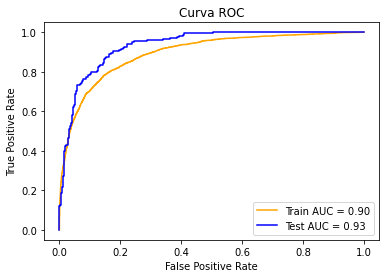

Parcelas con acierto:  33 de 35   94.29%
Test ROC AUC: 0.9336489795918367
Exito min:  0.39804572 
Exito max:  0.8883115 
Exito promedio:  0.7042361585964951
Exito * accuracy =  0.6197278195649157
Exito * accuracy / (Exito + accuracy) =  0.39118398870149784
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.93       525
         1.0       0.77      0.79      0.78       175

    accuracy                           0.89       700
   macro avg       0.85      0.86      0.85       700
weighted avg       0.89      0.89      0.89       700



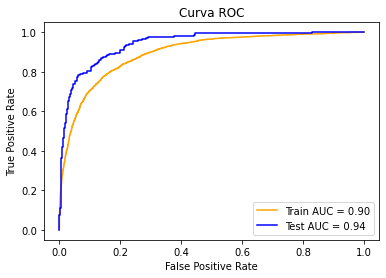

Parcelas con acierto:  34 de 35   97.14%
Test ROC AUC: 0.9432925170068027
Exito min:  0.507647 
Exito max:  0.8622673 
Exito promedio:  0.7222603114017306
Exito * accuracy =  0.6417798767026807
Exito * accuracy / (Exito + accuracy) =  0.3984152166714659
              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83       525
         1.0       0.49      0.49      0.49       175

    accuracy                           0.75       700
   macro avg       0.66      0.66      0.66       700
weighted avg       0.75      0.75      0.75       700



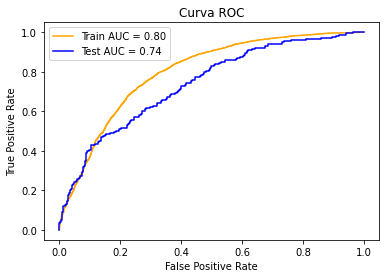

Parcelas con acierto:  31 de 35   88.57%
Test ROC AUC: 0.7376544217687075
Exito min:  0.36867607568559757 
Exito max:  0.905327 
Exito promedio:  0.6125879525496618
Exito * accuracy =  0.4576907131192473
Exito * accuracy / (Exito + accuracy) =  0.3366039144341715
              precision    recall  f1-score   support

         0.0       0.91      0.92      0.91       525
         1.0       0.74      0.72      0.73       175

    accuracy                           0.87       700
   macro avg       0.82      0.82      0.82       700
weighted avg       0.87      0.87      0.87       700



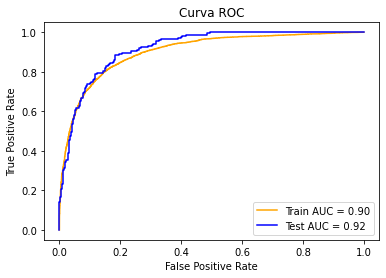

Parcelas con acierto:  34 de 35   97.14%
Test ROC AUC: 0.9199564625850339
Exito min:  0.42395476499885193 
Exito max:  0.8880861 
Exito promedio:  0.6958067624765888
Exito * accuracy =  0.6033638640332706
Exito * accuracy / (Exito + accuracy) =  0.3860417869260433
              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90       525
         1.0       0.73      0.63      0.68       175

    accuracy                           0.85       700
   macro avg       0.81      0.78      0.79       700
weighted avg       0.84      0.85      0.85       700



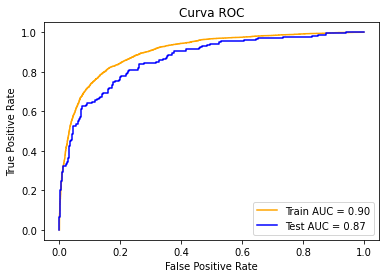

Parcelas con acierto:  32 de 35   91.43%
Test ROC AUC: 0.865774149659864
Exito min:  0.30149657 
Exito max:  0.8786618 
Exito promedio:  0.6481383109862429
Exito * accuracy =  0.5509175643383064
Exito * accuracy / (Exito + accuracy) =  0.3677347814272439
              precision    recall  f1-score   support

         0.0       0.80      0.94      0.87       525
         1.0       0.63      0.29      0.39       175

    accuracy                           0.78       700
   macro avg       0.72      0.62      0.63       700
weighted avg       0.76      0.78      0.75       700



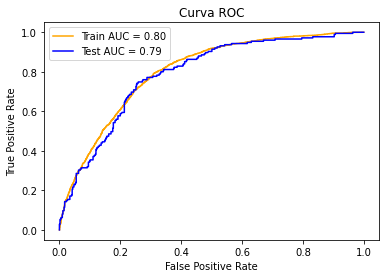

Parcelas con acierto:  19 de 35   54.29%
Test ROC AUC: 0.7885823129251701
Exito min:  0.2381653298339954 
Exito max:  0.8806565 
Exito promedio:  0.535149483121824
Exito * accuracy =  0.4174165968350227
Exito * accuracy / (Exito + accuracy) =  0.3173909902957829
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89       510
         1.0       0.66      0.66      0.66       170

    accuracy                           0.83       680
   macro avg       0.77      0.78      0.77       680
weighted avg       0.83      0.83      0.83       680



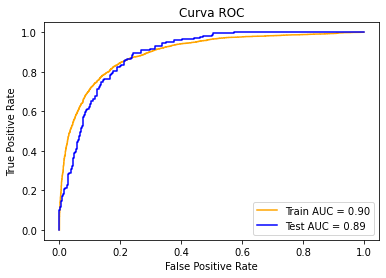

Parcelas con acierto:  32 de 34   94.12%
Test ROC AUC: 0.8922837370242215
Exito min:  0.4961976337088048 
Exito max:  0.89627004 
Exito promedio:  0.6726862568653251
Exito * accuracy =  0.558923139895454
Exito * accuracy / (Exito + accuracy) =  0.37173105121380745
              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91       510
         1.0       0.73      0.68      0.71       170

    accuracy                           0.86       680
   macro avg       0.81      0.80      0.81       680
weighted avg       0.85      0.86      0.86       680



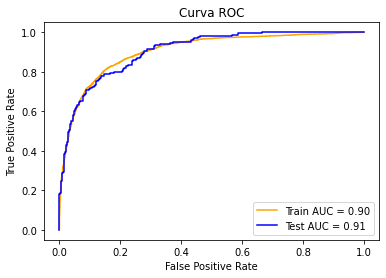

Parcelas con acierto:  29 de 34   85.29%
Test ROC AUC: 0.9067589388696655
Exito min:  0.39308146 
Exito max:  0.921116 
Exito promedio:  0.6677382503118956
Exito * accuracy =  0.572487352840934
Exito * accuracy / (Exito + accuracy) =  0.3753790960409603
              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89       510
         1.0       0.68      0.65      0.66       170

    accuracy                           0.84       680
   macro avg       0.78      0.77      0.78       680
weighted avg       0.83      0.84      0.83       680



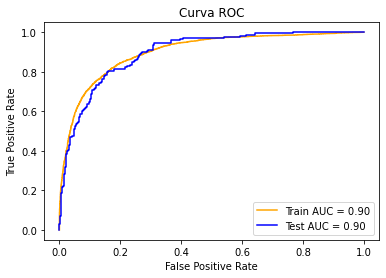

Parcelas con acierto:  31 de 34   91.18%
Test ROC AUC: 0.8969204152249135
Exito min:  0.38288796 
Exito max:  0.86550736 
Exito promedio:  0.6630150391878807
Exito * accuracy =  0.5538125621451709
Exito * accuracy / (Exito + accuracy) =  0.3696250267301686
              precision    recall  f1-score   support

         0.0       0.84      0.91      0.88       510
         1.0       0.64      0.50      0.56       170

    accuracy                           0.81       680
   macro avg       0.74      0.70      0.72       680
weighted avg       0.79      0.81      0.80       680



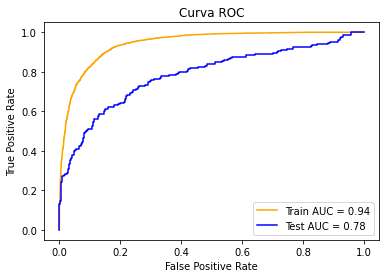

Parcelas con acierto:  27 de 34   79.41%
Test ROC AUC: 0.78479815455594
Exito min:  0.23709315 
Exito max:  0.8802024 
Exito promedio:  0.6106154433160623
Exito * accuracy =  0.4920842102017679
Exito * accuracy / (Exito + accuracy) =  0.34739497054071267


In [149]:
carpeta = "Optuna-XGBoost-20230214"
num_trial_best = obtenerParametrosOptimosXGBoost(carpeta = carpeta, n_splits = 10, random_state = 33, normalizacion=[0,1], n_trials=100)

# carga el mejor modelo
best_model_file = os.path.join(carpeta, f"model_trial_{num_trial_best}.joblib")
params, score, best_model = joblib.load(best_model_file)

probarMejorModelo(best_model, umbral=0.6)

El mejor modelo:
 - 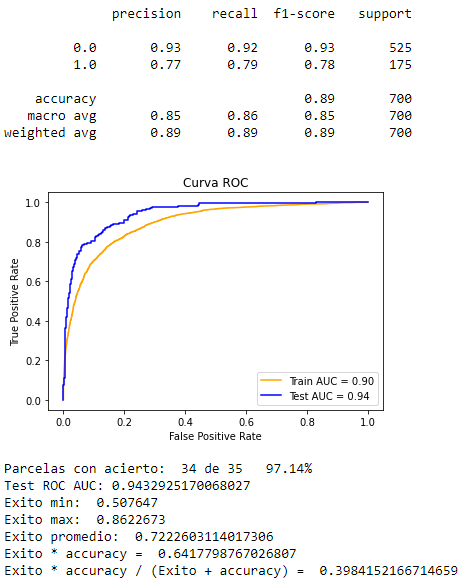